# Notebook to serve as baseline to re-write shearAzimuthalAverager
## build on : data_and_model_demo_DC2

### created by Mijin, Lucie & Marina
################################################################

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
from astropy import units as u
import GCRCatalogs
#from clmm import ShearAzimuthalAverager

### Read in the data (here cosmoDC2)

In [2]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [3]:
# get a massive halo at intermediate redshift
massive_halos = extragalactic_cat.get_quantities(['halo_mass', 'redshift','ra', 'dec'],\
                                                 filters=['halo_mass > 5e14','is_central==True','redshift<0.4'])

mass_list = massive_halos['halo_mass']
select = (mass_list == np.max(mass_list))
ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
mass_cl = mass_list[select][0]
print("mass = ", mass_cl/1e14,"*1e14 Msol", "\n ra = ", ra_cl, "\n dec = ", dec_cl,"\n z = ", z_cl)

# make a dictionary for cluster
cl_dict = {'z':z_cl, 'ra':ra_cl, 'dec': dec_cl}


mass =  12.391444739836395 *1e14 Msol 
 ra =  63.28980748965139 
 dec =  -39.647126899140524 
 z =  0.18532355457931704


In [4]:
# get galaxies around it
ra_min, ra_max = ra_cl-0.3, ra_cl+0.3
dec_min, dec_max = dec_cl-0.3, dec_cl+0.3
z_min = z_cl + 0.1
z_max = 1.5

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
                ]

z_filters = ['redshift >= {}'.format(z_min),'redshift < {}'.format(z_max)]

gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'shear_1', 'shear_2', 'shear_2_phosim', 'shear_2_treecorr',\
                                            'redshift', 'convergence'], filters=(coord_filters + z_filters))

# store the results into an astropy table
dat = Table([gal_cat['galaxy_id'],gal_cat['ra'],gal_cat['dec'],gal_cat['shear_1'],\
          gal_cat['shear_2'],gal_cat['redshift'],gal_cat['convergence']], \
          names=('id','ra','dec', 'gamma1', 'gamma2', 'z', 'kappa'))

print ("number of galaxies selected = ", len(dat))

number of galaxies selected =  448646


# NEW PIECE OF CODE #################################################################

## Prepare your data

In [5]:
#data_type = "simu" or data_type = "real"
data_type = "simu"

#define cosmo
cosmo = extragalactic_cat.cosmology

if data_type == "simu":
    g1 = dat['gamma1'] / (1 - dat['kappa'])
    g2 = dat['gamma2'] / (1 - dat['kappa'])

## Computes the tangential and cross shear profiles

In [6]:
def compute_theta_phi(ra_l, dec_l, ra_s, dec_s, sky="flat"):
    
    """ Returns the characteristic angles of the lens system
    
    Parameters
    ----------
    ra_l, dec_l, ra_s, dec_s: float vectors
        ra and dec of the lens (l) and source (s)  in decimal degrees
    sky: str
        'flat' uses the flat sky approximation (default) and 'curved' uses exact angles
    Returns
    -------
    theta, phi: float vectos
        in radians
    
    """

    dx = (ra_s-ra_l)*u.deg.to(u.rad) * np.cos(dec_l *u.deg.to(u.rad))             
    dy = (dec_s - dec_l)*u.deg.to(u.rad)                 
    phi = np.arctan2(dy, -dx)     
    
    if (sky == "curved"):
        coord_l = SkyCoord(ra_l*u.deg,dec_l*u.deg)
        coord_s = SkyCoord(ra_s*u.deg,dec_s*u.deg)
        theta = coord_l.separation(coord_s).to(u.rad).value

    else:                     
        theta =  np.sqrt(dx**2 + dy**2)

    return theta, phi


In [7]:
def compute_g_t(g1,g2,phi):

    """ Computes the tangential shear for each source in the galaxy catalog

    
    Parameters
    ----------
    g1,g2: float vectors
        ellipticity or shear for each source in the galaxy catalog
    phi: float vector
        as defined in comput_theta_phi

    Returns
    -------
    g_t: float vector
        tangential shear (need not be reduced shear)
    Notes
    -----
    g_t = - (g_1 * \cos(2\phi) + g_2 * \sin(2\phi)) [cf. eqs. 7-8 of Schrabback et al. 2018, arXiv:1611.03866]
    
    """ 
 
    g_t = - (g1 * np.cos(2*phi) + g2 * np.sin(2*phi))
 
    return g_t


In [8]:
def compute_g_x(g1,g2,phi):
    
     """ computes cross shear for each source in galaxy catalog
    
    Parameters
    ----------
    g1, g2,: float vectors
        ra and dec of the lens (l) and source (s)  in decimal degrees
    phi: float vector
        as defined in comput_theta_phi
    Returns
    -------
    gx: float vector
        cross shear
    Notes
    -----
    Computes the cross shear for each source in the catalog as:
    g_x = - g_1 * \sin(2\phi) + g_2 * \cos(2\phi)    [cf. eqs. 7-8 of Schrabback et al. 2018, arXiv:1611.03866]
    
    """ 
 
    g_x = - g1 * np.sin(2*phi) + g2 *np.cos(2*phi)

    return g_x

In [9]:
def compute_shear(ra_l,dec_l,ra_s, dec_s, g1, g2, sky = "flat"):
     """ wrapper that returns tangential and cross shear along 
         with radius in radians
    
    Parameters
    ----------
    ra_l, dec_l: float 
        ra and dec of lens in decimal degrees
    ra_s, dec_s: float vector 
        ra and dec of source in decimal degrees
    g1, g2: float
        shears or ellipticities from galaxy table
    sky: str
        'flat' uses the flat sky approximation (default) and 'curved' uses exact angles
    Returns
    -------
    gt: float vector
        tangential shear
    gx: float vector
        cross shear
    theta: float vector
        radius in radians
    Notes
    -----
    Computes the cross shear for each source in the galaxy catalog as:
    g_x = - g_1 * \sin(2\phi) + g_2 * \cos(2\phi)
    g_t = - (g_1 * \cos(2\phi) + g_2 * \sin(2\phi)) [cf. eqs. 7-8 of Schrabback et al. 2018, arXiv:1611.03866]
    """ 
    
  
    theta, phi = compute_theta_phi(ra_l, dec_l, ra_s, dec_s, sky = sky)
    g_t = compute_g_t(g1,g2,phi)
    g_x = compute_g_x(g1,g2,phi)

    return theta, g_t, g_x


In [140]:
#HERE CONVERT FUNCTION
#
#
#
#
#

In [18]:
def make_bins(rmin, rmax, n_bins=10, log_bins=False):
    """ 
    define equal sized bins with an array of n_bins+1 bin edges
    
    Parameters
    ----------
    rmin, rmax,: float
        minimum and and maximum range of data (any units)
    n_bins: float
        number of bins you want to create
    log_bins: bool
        set to 'True' equal sized bins in log space
    Returns
    -------
    binedges: float array
        n_bins+1 dimensional array that defines bin edges
    
    """ 
    
    if (log_bins==True):
        rmin = np.log(rmin)
        rmax = np.log(rmax)
        logbinedges = np.linspace(rmin, rmax, n_bins+1, endpoint=True)
        binedges = np.exp(logbinedges)
    else:
        binedges = np.linspace(rmin, rmax, n_bins+1, endpoint=True)
            
    return binedges


In [11]:
def make_shear_profile(radius, g, bins = None):
    
    """ returns astropy table containing shear profile of either tangential or cross shear

       Parameters
    ----------
    radius: float vector
        distance (physical or angular) between source galaxy to cluster center
    g: float vector
        either tangential or cross shear (g_t or g_x)
    bins: float array
        user defined n_bins + 1 dimensional array of bins, if 'None', the default is 10 equally spaced radial bins
    Returns
    -------
    r_profile: float array
        centers of radial bins
    g_profile: float array
        average shears per bin
    gerr_profile: float array
        standard deviation of shear per bin
    
    """  
    if bins == None:
        nbins = 10
        bins = np.linspace(np.min(radius),np.max(radius), nbins)

    g_profile = np.zeros(len(bins) - 1)
    gerr_profile = np.zeros(len(bins) - 1)
    r_profile =  np.zeros(len(bins) - 1)

    for i in range(len(bins)-1):
        cond = (radius>= bins[i]) & (radius < bins[i+1])
        index = np.where(cond)[0]
        r_profile[i] = np.average(radius[index])
        g_profile[i] = np.average(g[index])
        if len(index) != 0:
            gerr_profile[i] = np.std(g[index]) / np.sqrt(float(len(index)))
        else:
            gerr_profile[i] = np.nan

    return r_profile, g_profile, gerr_profile


In [12]:
def plot_profiles(r, gt, gterr, gx=None, gxerr=None, r_units = "" ):
    
    """ plot shear profiles for validation
    Parameters
    ----------
    r: float vector
        radius 
    gt: float vector
        tangential shear
    gterr:float vector   
        error on tangential shear
    gx: float vector     
        cross shear
    gxerr: float vector    
        error on cross shear 
    Returns
    -------
        a 
    """
    
    plt.plot(r,gt,'bo-', label = "tangential shear")
    plt.errorbar(r,gt,gterr)
    
    if type(gx) is np.ndarray:
        plt.plot(r,gx,'ro-', label = "cross shear")
        plt.errorbar(r,gx,gxerr)

    plt.legend()
    plt.xlabel("r ["+ r_units +"]")
    plt.ylabel('$\\gamma$')
    figure = 
    axis = 
    return(figure, axis);

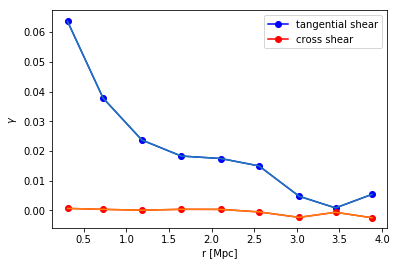

In [13]:
theta, g_t , g_x = compute_shear(ra_cl, dec_cl, dat['ra'], dat['dec'], g1, g2, sky = "curved")

#CONVERT FUNCTION
rMpc = theta * cosmo.angular_diameter_distance(z_cl).value


r, gt, gterr = make_shear_profile(rMpc, g_t)
r, gx, gxerr = make_shear_profile(rMpc, g_x)
plot_profiles(r, gt,gterr,gx,gxerr, "Mpc")

In [20]:
make_bins(1,10,9,False)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])